<a href="https://colab.research.google.com/github/instrat-pl/pypsa-pl/blob/main/notebooks/pypsa_pl_mini_capex_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyPSA-PL-mini: OPEX+CAPEX, all sectors

Simplified energy model for rapid testing and education.

Example of joint OPEX and CAPEX optimisation for all sectors.

Version 1.0

This notebook is released under [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact person:** Patryk Kubiczek (patryk.kubiczek@instrat.pl)

## How to use it?

**Start by making your own copy of this notebook (File > Save a copy in Drive).** This notebook, containing an application of the  PyPSA-PL-mini model, is synchronised with the GitHub repository https://github.com/instrat-pl/pypsa-pl. To play with the model, create your own copy of this notebook. 

Run the "Configuration" cells which will clone the PyPSA-PL repository into your Google Colab space and which will install all the required libraries. This might take up to a few minutes. After the configuration is finished, you can proceed to experiment with PyPSA-PL-mini. Have fun!

## Configuration (run each cell just once)

In [1]:
import sys
import os

# Optionally install pl_PL.UTF-8 locale in Google Colab
# Source: https://stackoverflow.com/questions/67045349/change-locale-for-google-colab

skip_installing_pl_locale = True

if "google.colab" in sys.modules and not skip_installing_pl_locale:
  # Install pl_PL
  !/usr/share/locales/install-language-pack pl_PL.UTF-8
  !dpkg-reconfigure locales
    
  # Restart Python process to pick up the new locales
  os.kill(os.getpid(), 9)

In [2]:
import sys
import os
from pathlib import Path

instrat_user = False
force_installation = False

if "google.colab" in sys.modules:

  %cd "/content"

  if instrat_user:  
    
    from google.colab import drive
    root = "/content/drive"
    drive.mount(root)

    def project_dir(*path):
      return Path(root, "MyDrive", "Colab", "PyPSA-PL-mini", *path)

  else:
    
    from google.colab import userdata
    # ghtoken = userdata.get("GHTOKEN")

    !rm -rf pypsa-pl
    # !git clone https://{ghtoken}@github.com/instrat-pl/pypsa-pl.git
    !git clone https://github.com/instrat-pl/pypsa-pl.git

    def project_dir(*path):
      return Path("/content", "pypsa-pl", *path)

  %cd {str(project_dir())}

  if not instrat_user or force_installation:
    !pip install poetry --quiet
    !poetry config virtualenvs.in-project false
    !poetry config virtualenvs.path {str(project_dir("venv"))}
    !poetry install --no-ansi
    # ipywidgets have to be downgraded in Google Colab
    !poetry add ipywidgets@7.7.2 --no-ansi
    # Download and install Work Sans font
    !mkdir fonts
    %cd fonts  
    !wget https://github.com/weiweihuanghuang/Work-Sans/raw/master/fonts/ttf/WorkSans-Regular.ttf
    !wget https://github.com/weiweihuanghuang/Work-Sans/raw/master/fonts/ttf/WorkSans-Medium.ttf
    from matplotlib import font_manager
    font_files = ["WorkSans-Regular.ttf", "WorkSans-Medium.ttf"]
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)
    %cd ..

  v = f"{sys.version_info.major}.{sys.version_info.minor}"
  venv_location = !poetry env info -p
  VENV_PATH = os.path.join(venv_location[0], "lib", f"python{v}", "site-packages")
  sys.path.insert(0, VENV_PATH)  
  
  SRC_PATH = str(project_dir("src"))
  sys.path.insert(0, SRC_PATH)

else:
  %load_ext autoreload
  %autoreload 2

import pypsa_pl.config

## Energy system model

### Specify parameters

In [3]:
params = {
    # Run name and year
    "run_name": "pypsa_pl_mini_capex_all",
    "year": 2023,
    # Input data
    "technology_carrier_definitions": "full",
    "technology_cost_data": "instrat_2024",
    "installed_capacity": "historical_totals",
    "annual_energy_flows": "historical",
    "capacity_utilisation": "historical",
    "capacity_addition_potentials": "instrat_projection", # irrelevant in this example
    "timeseries": "mini",
    # CO2 emissions
    "co2_emissions": None,  # no limit on CO2 emissions
    # Weather year
    "weather_year": 2012,
    # Other assumptions
    "discount_rate": 0.045,
    "investment_cost_start_year": 2021,
    "invest_from_zero": True,
    "optimise_industrial_capacities": False,
    "investment_technologies": [
        # Power
        "wind onshore",
        "solar PV ground",
        "battery large power",
        "battery large charger",
        "battery large storage",
        # Heating - centralised
        "heat pump large AW",
        "resistive heater large",
        "heat storage large tank discharge",
        "heat storage large tank charge",
        "heat storage large tank",
        # Heating - decentralised
        "heat pump small AW",
        "resistive heater small",
        "heat storage small discharge",
        "heat storage small charge",
        "heat storage small",
        # Mobility
        "BEV",
        "BEV battery",
        "BEV charger",
        # "BEV V2G", # if V2G scale factor is zero, do not optimise
        # Hydrogen
        "hydrogen electrolysis",
        "hydrogen storage",
    ],
    "retirement_technologies": [
        # Power
        # "hard coal power old",
        # "hard coal power SC",
        # "lignite power old",
        # "lignite power SC",
        # CHP
        "hard coal CHP",
        # Heating - centralised
        "hard coal heat",
        # Heating - decentralised
        "hard coal boiler",
        "natural gas boiler",
        "other boiler",
        # Mobility
        "ICE vehicle",
        # Hydrogen
        "natural gas reforming",
        # Virtual components - always need to be included
        "centralised space heating",
        "centralised water heating",
        "centralised other heating",
        "decentralised space heating",
        "decentralised water heating",
        "light vehicle mobility",
        "hydrogen",
    ],
    "constrained_energy_flows": [
        "space heating final use",
        "water heating final use",
        "other heating final use",
        "light vehicle mobility final use",
        "hydrogen final use",
    ],
    "reoptimise_with_fixed_capacities": False, # if True, only OPEX determines marginal prices
    # CHP behavior
    "fix_public_chp": False,
    "fix_industrial_chp": True,
    "share_space_heating": 0.75,
    # Electricity sector
    "prosumer_self_consumption": 0.2,
    "p_min_synchronous": 0,  # irrelevant in this example - we set p_min_pu for thermal power plants
    "synchronous_carriers": [],
    # Heating sector
    "heat_capacity_utilisation": 0.2,
    "centralised_heating_share": None, # determined by district heating capacities
    # Light vehicle mobility sector
    "light_vehicle_mobility_utilisation": 0.021,
    "bev_flexibility_factor": 0.5,
    "bev_flexibility_max_to_mean_ratio": 1.33,
    "bev_flexible_share": 0.5,  # if exact 0 is desired, set bev_flexibility_factor=0 instead
    "bev_availability_max": 0.9,
    "bev_availability_mean": 0.7,
    "minimum_bev_charge_level": 0.75,
    "minimum_bev_charge_hour": 6,
    # Technical details - they should not influence numerical results
    "space_heating_utilisation": 0.1,
    "water_heating_utilisation": 1,
    "other_heating_utilisation": 1,
    "hydrogen_utilisation": 1,
    "inf": 999999,
    "reverse_links": True,
    "solver": "highs",
    "solver_tolerance": 1e-6,
}

### Prepare inputs


In [4]:
import logging
import numpy as np
from pypsa_pl.build_network import load_and_preprocess_inputs


def custom_operation(inputs, params):

    def add_qualifier_to_technology(df, technology, qualifier):
        df.loc[df["technology"] == technology, "qualifier"] = qualifier
        return df

    # Identify solar PV roof as prosumer electricity source
    inputs["installed_capacity"] = add_qualifier_to_technology(
        inputs["installed_capacity"],
        "solar PV roof",
        "prosumer",
    )

    def remove_capacities(df, technologies):
        df = df[~df["technology"].isin(technologies)]
        return df

    # We do not model cross border electricity flows in this simplified example
    inputs["installed_capacity"] = remove_capacities(
        inputs["installed_capacity"],
        technologies=[
            "electricity export AC",
            "electricity import AC",
            "electricity export DC",
            "electricity import DC",
        ],
    )

    def remove_p_max_pu_annual_technology_input(df, keep_techs=[]):
        df = df[
            ~(df["parameter"] == "p_max_pu_annual")
            | df["technology"].isin(keep_techs)
            | df["technology"].str.startswith(("wind", "solar"))
        ]
        return df

    inputs["technology_cost_data"] = remove_p_max_pu_annual_technology_input(
        inputs["technology_cost_data"],
        keep_techs=["nuclear power large"],
    )

    def remove_chp_capacity_utilisation_input(df, qualifiers=["public", "industrial"]):
        df = df[
            ~(df["technology"].str.contains("CHP") & df["qualifier"].isin(qualifiers))
        ]
        return df

    qualifiers = []
    if not params["fix_public_chp"]:
        qualifiers += ["public"]
    if not params["fix_industrial_chp"]:
        qualifiers += ["industrial"]
    inputs["capacity_utilisation"] = remove_chp_capacity_utilisation_input(
        inputs["capacity_utilisation"], qualifiers=qualifiers
    )

    def rescale_v2g(df_tech, df_cap, factor):
        df_tech.loc[
            (df_tech["technology"] == "BEV V2G")
            & (df_tech["parameter"] == "parent_ratio"),
            "value",
        ] *= factor
        df_cap.loc[df_cap["technology"] == "BEV V2G", "nom"] *= factor
        return df_tech, df_cap

    inputs["technology_cost_data"], inputs["installed_capacity"] = rescale_v2g(
        inputs["technology_cost_data"],
        inputs["installed_capacity"],
        factor=0,
    )

    def add_p_min_pu_constraint(df, technology, qualifier="", p_min_pu=0):
        df["qualifier"] = df["qualifier"].fillna("")
        df = df.set_index(["area", "technology", "qualifier", "year", "parameter"])
        df.loc[("PL", technology, qualifier, params["year"], "p_min_pu"), "value"] = (
            p_min_pu
        )
        df = df.reset_index()
        df["qualifier"] = df["qualifier"].replace("", np.nan)
        return df

    # Add 50% minimum load constraint for nuclear power plants
    inputs["capacity_utilisation"] = add_p_min_pu_constraint(
        inputs["capacity_utilisation"], "nuclear power large", p_min_pu=0.5
    )

    def subtract_endogenous_electricity_consumption_and_losses(df_flow, df_cap):
        distribution_loss = 0.04
        efficiency = {
            "resistive heater small": 1,
            "heat pump small AW": 3.1,
            "BEV": 0.85 * 0.9,
        }
        utilisation = {
            "resistive heater small": params["heat_capacity_utilisation"],
            "heat pump small AW": params["heat_capacity_utilisation"],
            "BEV": params["light_vehicle_mobility_utilisation"],
        }

        # Identify sectoral electricity demand sources
        df = df_cap.loc[
            (
                (df_cap["technology"] == "resistive heater small")
                & (df_cap["qualifier"] == "to resistive heater bus")
                # There are also resistive heaters supporting heat pumps - we assume they have negligibly small utilisation
            )
            | (df_cap["technology"] == "heat pump small AW")
            | (df_cap["technology"] == "BEV"),
            ["area", "technology", "build_year", "nom"],
        ].rename(columns={"build_year": "year", "nom": "sectoral_consumption"})
        # Calculate final energy demand in TWh from capacities and utilisation
        df["sectoral_consumption"] *= 8760 * df["technology"].map(utilisation) / 1e6
        # Calculate sectoral electricity consumption taking into account technology efficiency
        df["sectoral_consumption"] /= df["technology"].map(efficiency)

        # Aggregate and merge on df_flow
        df = df.drop(columns="technology").groupby(["area", "year"]).sum()
        sectoral_consumption = df.loc[("PL", params["year"]), "sectoral_consumption"]
        df_flow = df_flow.merge(df, on=["area", "year"], how="left")

        # (1) Subtract electricity grid losses
        is_electricity_final_use = df_flow["carrier"] == "electricity final use"
        df_flow.loc[is_electricity_final_use, "value"] *= 1 - distribution_loss
        logging.info(
            f"Subtracting {(distribution_loss * 100):.0f}% electricity distribution loss"
        )

        # (2) Subtract sectoral electricity consumption
        df_flow["sectoral_consumption"] *= -1
        df_flow.loc[is_electricity_final_use, "value"] = df_flow.loc[
            is_electricity_final_use, ["value", "sectoral_consumption"]
        ].sum(axis=1)
        df_flow = df_flow.drop(columns="sectoral_consumption")
        logging.info(
            f"Subtracting endogenous sectoral electricity consumption: {sectoral_consumption:.1f} TWh ({params['year']})"
        )

        df_flow["value"] = df_flow["value"].round(1)

        return df_flow

    inputs["annual_energy_flows"] = (
        subtract_endogenous_electricity_consumption_and_losses(
            inputs["annual_energy_flows"], inputs["installed_capacity"]
        )
    )

    def add_new_capacities(df, technologies_qualifiers, nom=0, cumulative=False):
        df = df.set_index("name")
        for technology, qualifier in technologies_qualifiers:
            area = "PL"
            area2 = np.nan
            build_year = params["year"]
            retire_year = np.nan if not cumulative else params["year"]
            df.loc[
                f"PL {technology}"
                + (f" {qualifier}" if qualifier == qualifier else "")
                + " new"
            ] = [
                area,
                area2,
                technology,
                qualifier,
                build_year,
                retire_year,
                cumulative,
                nom,
            ]
        df = df.reset_index()
        return df

    # Add candidate capacities to extend
    inputs["installed_capacity"] = add_new_capacities(
        inputs["installed_capacity"],
        technologies_qualifiers=[
            # Power
            ("wind onshore", np.nan),
            ("solar PV ground", np.nan),
            ("battery large power", np.nan),
            ("battery large charger", np.nan),
            ("battery large storage", np.nan),
            # Heating - centralised
            *[
                tech_qual
                for bus in ["hard coal bus", "natural gas bus"]
                for tech_qual in [
                    ("heat pump large AW", f"to {bus}"),
                    ("resistive heater large", f"to {bus}"),
                    ("heat storage large tank charge", f"to and from {bus}"),
                    ("heat storage large tank discharge", f"to and from {bus}"),
                    ("heat storage large tank", f"to and from {bus}"),
                ]
            ],
            # Heating - decentralised
            ("heat pump small AW", "to heat pump bus"),
            ("resistive heater small", "to heat pump bus"),
            ("heat storage small discharge", "to and from heat pump bus"),
            ("heat storage small charge", "to and from heat pump bus"),
            ("heat storage small", "to and from heat pump bus"),
            # Mobility
            ("BEV", "to BEV bus"),
            ("BEV battery", np.nan),
            ("BEV charger", np.nan),
            ("BEV V2G", np.nan),
            # Hydrogen
            ("hydrogen electrolysis", "to electrolysis bus"),
            ("hydrogen storage", "to and from electrolysis bus"),
        ],
    )

    inputs["installed_capacity"] = add_new_capacities(
        inputs["installed_capacity"],
        technologies_qualifiers=[
            # Virtual components
            ("hydrogen", "from electrolysis bus"),
        ],
        nom=np.inf,
        cumulative=True,
    )

    def set_max_growth(df, carriers_values, attr="max_growth"):
        df = df.set_index(["area", "carrier", "year", "attribute"])
        for carrier, value in carriers_values:
            df.loc[("PL", carrier, params["year"], attr)] = [value]
        df = df.reset_index()
        return df

    # Set limits to capacity growth of sectoral technologies
    inputs["capacity_addition_potentials"] = set_max_growth(
        inputs["capacity_addition_potentials"],
        [
            ("resistive heater large", 1200),
            ("heat pump large", 600),
            ("heat storage large tank discharge", 1200),
            ("heat pump small", 1.0e6 * 0.008),
            ("BEV", 1.7e6 * 0.01),
            ("hydrogen electrolysis", 900),
        ],
    )

    return inputs


inputs = load_and_preprocess_inputs(params, custom_operation=custom_operation)

2024-11-09 00:05:55 [INFO] NumExpr defaulting to 8 threads.
2024-11-09 00:05:59 [INFO] Subtracting 4% electricity distribution loss
2024-11-09 00:05:59 [INFO] Subtracting endogenous sectoral electricity consumption: 9.1 TWh (2023)


In [5]:
# name = "technology_carrier_definitions"
# name = "technology_cost_data"
# name = "installed_capacity"
# name = "annual_energy_flows"
# name = "capacity_utilisation"
# name = "co2_cost"
# name = "final_use"
name = "capacity_addition_potentials"

inputs[name].tail()

,area,carrier,year,attribute,value
93,PL,heat pump large,2023,max_growth,600.0
94,PL,heat storage large tank discharge,2023,max_growth,1200.0
95,PL,heat pump small,2023,max_growth,8000.0
96,PL,BEV,2023,max_growth,17000.0
97,PL,hydrogen electrolysis,2023,max_growth,900.0


### Create PyPSA network

In [6]:
from pypsa_pl.build_network import create_custom_network

network = create_custom_network(params)

network

Empty PyPSA Network 'pypsa_pl_mini_capex_all'
Components: none
Snapshots: 1

### Add snapshots

In [7]:
from pypsa_pl.build_network import add_snapshots

add_snapshots(network, params)

network.snapshots

Index(['2023-03-09 00:00:00', '2023-03-09 01:00:00', '2023-03-09 02:00:00',
       '2023-03-09 03:00:00', '2023-03-09 04:00:00', '2023-03-09 05:00:00',
       '2023-03-09 06:00:00', '2023-03-09 07:00:00', '2023-03-09 08:00:00',
       '2023-03-09 09:00:00',
       ...
       '2023-11-01 14:00:00', '2023-11-01 15:00:00', '2023-11-01 16:00:00',
       '2023-11-01 17:00:00', '2023-11-01 18:00:00', '2023-11-01 19:00:00',
       '2023-11-01 20:00:00', '2023-11-01 21:00:00', '2023-11-01 22:00:00',
       '2023-11-01 23:00:00'],
      dtype='object', name='snapshot', length=672)

### Add carriers

In [8]:
from pypsa_pl.build_network import add_carriers

add_carriers(network, inputs, params)

network.carriers

,color,order,aggregation,co2_emissions,nice_name,max_growth,max_relative_growth
Carrier,,,,,,,
BEV,#153d80,521,BEV,NaN,,inf,0.0
BEV V2G,#153d80,251,BEV,NaN,,inf,0.0
BEV battery,#153d80,522,BEV,NaN,,inf,0.0
BEV charger,#153d80,523,BEV,NaN,,inf,0.0
DSR reduction,#1b1c1e,291,DSR,NaN,,inf,0.0
...,...,...,...,...,...,...,...
solar PV roof,#e040fb,222,solar PV roof,NaN,,inf,0.0
space heating final use,#b6b6b7,2,heat final use,NaN,,inf,0.0
water heating final use,#b6b6b7,3,heat final use,NaN,,inf,0.0


### Add buses and areas

In [9]:
from pypsa_pl.build_network import add_buses_and_areas

add_buses_and_areas(network, inputs, params)

network.buses

,area,carrier,qualifier,v_nom,type,x,y,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,,,
PL BEV electricity,PL,BEV electricity,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL ICE vehicle fuel,PL,ICE vehicle fuel,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL battery large electricity,PL,battery large electricity,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL biogas,PL,biogas,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL biogas substrate,PL,biogas substrate,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL biomass wood,PL,biomass wood,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL electricity in,PL,electricity in,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL electricity out,PL,electricity out,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL hard coal,PL,hard coal,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,


### Add generating, consuming, and storing capacity (generators, links, stores)

#### Process installed capacity data and specify the relevant attributes

In [10]:
from pypsa_pl.build_network import process_capacity_data

df_cap = process_capacity_data(inputs, params)

df_cap.head()

,name,area,area2,technology,qualifier,build_year,retire_year,cumulative,nom,carrier,...,p_set,p_set_annual,p_max_pu,p_min_pu,e_min_pu,e_max_pu,p_set_pu_annual,p_min_pu_annual,p_set_pu,parent
6,PL BEV V2G 2023,PL,PL,BEV V2G,NaN,2023,2023.0,True,0.0,BEV V2G,...,NaN,NaN,1.0,0.0,0.0,1.0,NaN,0.0,NaN,PL BEV to BEV bus 2023
138,PL BEV V2G new,PL,PL,BEV V2G,NaN,2023,2042.0,False,0.0,BEV V2G,...,NaN,NaN,1.0,0.0,0.0,1.0,NaN,0.0,NaN,PL BEV to BEV bus new
3,PL BEV battery 2023,PL,NaN,BEV battery,NaN,2023,2023.0,True,1760.0,BEV battery,...,NaN,NaN,1.0,0.0,0.0,1.0,NaN,0.0,NaN,PL BEV to BEV bus 2023
136,PL BEV battery new,PL,NaN,BEV battery,NaN,2023,2042.0,False,0.0,BEV battery,...,NaN,NaN,1.0,0.0,0.0,1.0,NaN,0.0,NaN,PL BEV to BEV bus new
4,PL BEV charger 2023,PL,PL,BEV charger,NaN,2023,2023.0,True,360.0,BEV charger,...,NaN,NaN,1.0,0.0,0.0,1.0,NaN,0.0,NaN,PL BEV to BEV bus 2023


#### Specify which attributes are time dependent

In [11]:
from pypsa_pl.define_time_dependent_attributes import (
    define_time_dependent_attributes,
)


df_attr_t = define_time_dependent_attributes(df_cap, params)

df_attr_t

,carrier,technology,qualifier,attribute,profile_type
0,electricity final use,electricity final use,none,p_set,electricity final use load profile
1,solar PV ground,solar PV ground,none,p_max_pu,vres availability profile
2,solar PV roof,solar PV roof,prosumer,p_max_pu,vres availability profile
3,wind onshore,wind onshore,none,p_max_pu,vres availability profile
4,wind onshore,wind onshore old,none,p_max_pu,vres availability profile
...,...,...,...,...,...
80,BEV V2G,BEV V2G,none,p_min_pu,BEV charger min output pu profile
81,BEV charger,BEV charger,none,p_max_pu,BEV charger max output pu profile
82,BEV charger,BEV charger,none,p_min_pu,BEV charger min output pu profile
83,BEV battery,BEV battery,none,e_max_pu,BEV battery max SOC profile


#### Create actual components and fill them with data

In [12]:
from pypsa_pl.build_network import add_capacities

add_capacities(network, df_cap, df_attr_t, params)

2024-11-09 00:06:07 [INFO] Mean BEV storage flexibility: 2.96 kWh/BEV (flexible vehicles only)


In [13]:
network.generators.head()

,bus,area,carrier,technology,qualifier,aggregation,p_nom,p_nom_extendable,p_nom_min,p_nom_max,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
PL ICE vehicle fuel supply 2023,PL ICE vehicle fuel,PL,ICE vehicle fuel supply,ICE vehicle fuel supply,,ICE vehicle fuel supply,999999.0,False,999999.0,999999.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL biogas substrate supply 2023,PL biogas substrate,PL,biogas substrate supply,biogas substrate supply,,biogas substrate supply,999999.0,False,999999.0,999999.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL biomass wood supply 2023,PL biomass wood,PL,biomass wood supply,biomass wood supply,,biomass supply,999999.0,False,999999.0,999999.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL electricity final use 2023,PL electricity out,PL,electricity final use,electricity final use,,electricity final use,999999.0,False,999999.0,999999.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL hard coal supply 2023,PL hard coal,PL,hard coal supply,hard coal supply,,hard coal supply,999999.0,False,999999.0,999999.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [14]:
network.links.head()

,bus0,bus1,bus2,area,area2,carrier,technology,qualifier,aggregation,p_nom,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
PL BEV V2G 2023,PL electricity in,PL BEV electricity,,PL,PL,BEV V2G,BEV V2G,,BEV,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL BEV V2G new,PL electricity in,PL BEV electricity,,PL,PL,BEV V2G,BEV V2G,,BEV,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL BEV charger 2023,PL BEV electricity,PL electricity out,,PL,PL,BEV charger,BEV charger,,BEV,360.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL BEV charger new,PL BEV electricity,PL electricity out,,PL,PL,BEV charger,BEV charger,,BEV,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL BEV to BEV bus 2023,PL light vehicle mobility BEV,PL BEV electricity,,PL,PL,BEV,BEV,to BEV bus,BEV,360.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [15]:
network.stores.head()

,bus,area,carrier,technology,qualifier,aggregation,e_nom,e_nom_extendable,e_nom_min,e_nom_max,...,type,e_nom_mod,e_initial,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,marginal_cost_quadratic,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
PL BEV battery 2023,PL BEV electricity,PL,BEV battery,BEV battery,,BEV,1760.0,False,1760.0,1760.0,...,,0.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0
PL BEV battery new,PL BEV electricity,PL,BEV battery,BEV battery,,BEV,0.0,True,0.0,inf,...,,0.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0
PL battery large storage 2023,PL battery large electricity,PL,battery large storage,battery large storage,,battery large,600.0,False,600.0,600.0,...,,0.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0
PL battery large storage new,PL battery large electricity,PL,battery large storage,battery large storage,,battery large,0.0,True,0.0,inf,...,,0.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0
PL heat storage large tank to and from biomass and biogas bus 2023,PL heat storage large tank heat biomass and bi...,PL,heat storage large tank,heat storage large tank,to and from biomass and biogas bus,heat storage large,980.0,False,980.0,980.0,...,,0.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0


### Add flow constraints

In [16]:
from pypsa_pl.build_network import add_energy_flow_constraints

add_energy_flow_constraints(network, inputs, params)

# Non-electricity sectoral demands are specified as flow constraints
network.global_constraints

,type,investment_period,area,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,,
PL hydrogen final use flow 2023,operational_limit,NaN,PL,hydrogen final use,==,23700000.0,0.0
PL light vehicle mobility final use flow 2023,operational_limit,NaN,PL,light vehicle mobility final use,==,44900000.0,0.0
PL other heating final use flow 2023,operational_limit,NaN,PL,other heating final use,==,15200000.0,0.0
PL space heating final use flow 2023,operational_limit,NaN,PL,space heating final use,==,152800000.0,0.0
PL water heating final use flow 2023,operational_limit,NaN,PL,water heating final use,==,49800000.0,0.0


### Add capacity constraints

In [17]:
from pypsa_pl.build_network import add_capacity_constraints

add_capacity_constraints(network, inputs, params)

network.carriers[network.carriers["max_growth"] < np.inf]

,color,order,aggregation,co2_emissions,nice_name,max_relative_growth,max_growth
Carrier,,,,,,,
BEV,#153d80,521,BEV,NaN,,0.0,17000.0
heat pump large,#f4a6a5,301,heat pump large,NaN,,0.0,600.0
heat pump small,#f4a6a5,451,heat pump small,NaN,,0.0,8000.0
heat storage large tank discharge,#aa1817,331,heat storage large,NaN,,0.0,1200.0
hydrogen electrolysis,#80e5ff,611,hydrogen electrolysis,NaN,,0.0,900.0
resistive heater large,#e94d4c,311,resistive heater large,NaN,,0.0,1200.0


### Save input network

In [18]:
from pypsa_pl.config import data_dir

os.makedirs(data_dir("runs", params["run_name"]), exist_ok=True)
network.export_to_csv_folder(data_dir("runs", params["run_name"], "input_network"))

2024-11-09 00:06:09 [INFO] Exported network input_network has buses, generators, carriers, areas, stores, links, global_constraints


### Solve the model

In [19]:
from pypsa_pl.optimise_network import optimise_network

optimise_network(network, params)

2024-11-09 00:06:09 [INFO] Repeating time-series for each investment period and converting snapshots to a pandas.MultiIndex.
2024-11-09 00:06:17 [INFO] Fixed ratio of water heating to space heating: 0.33
2024-11-09 00:06:17 [INFO] Removing annual flow constraint for water heating
2024-11-09 00:06:18 [INFO] Fixed heat flows at 11 out of 11 heat buses
2024-11-09 00:06:18 [INFO] Fixed light vehicle mobility flows at 2 out of 2 light vehicle mobility buses
2024-11-09 00:06:18 [INFO]  Solve problem using Highs solver
2024-11-09 00:06:18 [INFO] Solver options:
 - threads: 4
 - solver: ipm
 - run_crossover: off
 - small_matrix_value: 1e-07
 - large_matrix_value: 1000000000000.0
 - primal_feasibility_tolerance: 9.999999999999999e-06
 - dual_feasibility_tolerance: 9.999999999999999e-06
 - ipm_optimality_tolerance: 1e-06
 - parallel: on
 - random_seed: 0
2024-11-09 00:06:19 [INFO] Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00,  9.12it/s]
2024-11-09 00:06:25 

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 1e+01]
  Cost   [1e+00, 1e+06]
  Bound  [4e+10, 4e+10]
  RHS    [6e-01, 2e+08]
Presolving model
81011 rows, 77727 cols, 251810 nonzeros  0s
66224 rows, 62940 cols, 238219 nonzeros  0s
49544 rows, 59336 cols, 205159 nonzeros  1s
35265 rows, 46569 cols, 156106 nonzeros  1s
32408 rows, 45056 cols, 149889 nonzeros  1s
Presolve : Reductions: rows 32408(-201595); columns 45056(-59169); elements 149889(-312665)
Solving the presolved LP
IPX model has 32408 rows, 45056 columns and 149889 nonzeros
Input
    Number of variables:                                45056
    Number of free variables:                           672
    Number of constraints:                              32408
    Number of equality constraints:                     13393
    Number of matrix entries:                           149889
    Matrix range:                                       [3e-04, 2

2024-11-09 00:07:14 [INFO]  Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 104225 primals, 234003 duals
Objective: 1.64e+11
Solver model: available
Solver message: optimal

2024-11-09 00:07:15 [INFO] The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Link-p_set, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


[PyPSA Network 'pypsa_pl_mini_capex_all'
 Components:
  - Area: 1
  - Bus: 42
  - Carrier: 93
  - Generator: 21
  - GlobalConstraint: 5
  - Link: 108
  - Store: 13
 Snapshots: 672]

In [20]:
network.model.constraints

linopy.model.Constraints
------------------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Link-ext-p_nom-lower (Link-ext)
 * Link-ext-p_nom-upper (Link-ext)
 * Store-ext-e_nom-lower (Store-ext)
 * Store-ext-e_nom-upper (Store-ext)
 * Generator-fix-p-lower (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-upper (snapshot, period, timestep, Generator-fix)
 * Generator-ext-p-lower (snapshot, period, timestep, Generator-ext)
 * Generator-ext-p-upper (snapshot, period, timestep, Generator-ext)
 * Generator-p_set (snapshot, period, timestep, Generator-p_set_i)
 * Link-fix-p-lower (snapshot, period, timestep, Link-fix)
 * Link-fix-p-upper (snapshot, period, timestep, Link-fix)
 * Link-ext-p-lower (snapshot, period, timestep, Link-ext)
 * Link-ext-p-upper (snapshot, period, timestep, Link-ext)
 * Link-p_set (snapshot, period, timestep, Link-p_set_i)
 * Store-fix-e-lower (snapshot, period, timestep, Store-fix)
 * Store-fix-e-uppe

### Save output network

In [21]:
network.export_to_csv_folder(data_dir("runs", params["run_name"], "output_network"))

2024-11-09 00:07:17 [INFO] Exported network output_network has buses, generators, carriers, areas, stores, links, global_constraints


### Analyse results

In [22]:
import pandas as pd


def append_annual_sum(df, value_cols=["value"]):
    agg_columns = ["carrier", "aggregation", "fuel"]
    agg = df.columns.intersection(agg_columns)
    assert len(agg) == 1
    agg = agg[0]
    return pd.concat(
        [
            df,
            df.groupby("year")
            .agg({agg: lambda x: "SUM", **{col: "sum" for col in value_cols}})
            .reset_index(),
        ]
    )

#### Display statistics

In [23]:
from pypsa_pl.process_output_network import calculate_statistics

df_stat = calculate_statistics(network)
df_stat

,year,component,area,aggregation,carrier,technology,qualifier,Optimal Capacity,Installed Capacity,Capacity Factor,Dispatch,Transmission,Withdrawal,Supply,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
0,2023,Generator,PL,ICE vehicle fuel supply,ICE vehicle fuel supply,ICE vehicle fuel supply,,999999.000000,999999.0,0.019044,1.668258e+08,0.0,0.000000e+00,1.668258e+08,NaN,0.000000e+00,4.587710e+10,4.587710e+10,275.000000
1,2023,Generator,PL,biogas substrate supply,biogas substrate supply,biogas substrate supply,,999999.000000,999999.0,0.000222,1.941810e+06,0.0,0.000000e+00,1.941810e+06,NaN,0.000000e+00,3.495257e+08,3.495257e+08,180.000000
2,2023,Generator,PL,biomass supply,biomass wood supply,biomass wood supply,,999999.000000,999999.0,0.008728,7.645418e+07,0.0,0.000000e+00,7.645418e+07,NaN,0.000000e+00,9.174502e+09,9.174502e+09,120.000000
3,2023,Generator,PL,electricity final use,electricity final use,electricity final use,,999999.000000,999999.0,0.015867,-1.389973e+08,0.0,1.389973e+08,0.000000e+00,NaN,0.000000e+00,0.000000e+00,-4.833915e+10,347.770416
4,2023,Generator,PL,hard coal supply,hard coal supply,hard coal supply,,999999.000000,999999.0,0.023412,2.050888e+08,0.0,0.000000e+00,2.050888e+08,NaN,0.000000e+00,5.110812e+10,5.110812e+10,249.199999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2023,Store,PL,heat storage large,heat storage large tank,heat storage large tank,to and from natural gas bus,5855.121129,1390.0,0.142189,-1.458602e+04,0.0,4.824536e+05,4.678675e+05,NaN,1.583403e+07,0.000000e+00,3.082960e+07,65.893865
113,2023,Store,PL,heat storage large,heat storage large tank,heat storage large tank,to and from other bus,590.000000,590.0,0.137086,-1.456734e+03,0.0,9.096544e+03,7.639810e+03,NaN,4.425000e+05,0.000000e+00,3.400412e+05,44.509119
114,2023,Store,PL,heat storage small,heat storage small,heat storage small,to and from heat pump bus,3999.999997,0.0,0.203565,-1.427873e+05,0.0,1.925092e+06,1.782305e+06,NaN,1.522514e+08,0.000000e+00,5.783779e+07,32.451113
115,2023,Store,PL,hydro PSH,hydro PSH storage,hydro PSH storage,,8470.000000,8470.0,0.555580,-6.705986e+01,0.0,1.053716e+06,1.053649e+06,NaN,0.000000e+00,0.000000e+00,3.004307e+08,285.133507


In [24]:
# Example of statistics use: curtailed vRES energy ratio
df = df_stat.groupby("carrier")[["Supply", "Curtailment"]].sum()
df = 1 / (1 + df["Supply"] / df["Curtailment"])
df = df[df > 0].round(3).rename("value").to_frame()
df

,value
carrier,
solar PV ground,0.000
solar PV roof,0.000
wind onshore,0.149


#### Plot capacity mixes

,year,carrier,value
0,2023,BEV V2G,0.00
1,2023,battery large power,0.15
2,2023,biogas CHP,0.28
3,2023,biomass wood CHP,0.46
4,2023,biomass wood power,0.40
5,2023,hard coal CHP,3.70
6,2023,hard coal power,15.14
7,2023,hydro PSH power,1.79
8,2023,hydro ROR,0.60
9,2023,lignite power,7.64


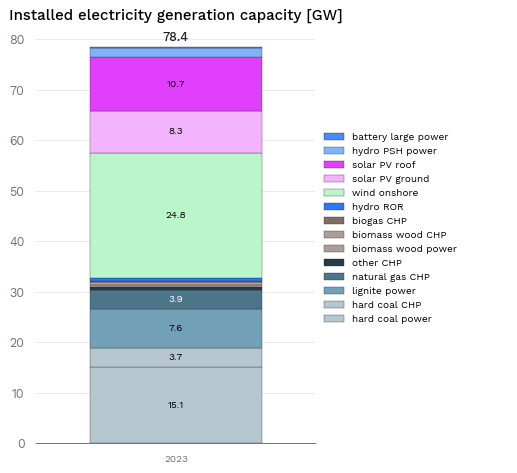

In [25]:
from pypsa_pl.plot_outputs import plot_installed_capacities

fig, df = plot_installed_capacities(
    network,
    bus_carriers=["electricity in"],
    carrier_name="electricity",
    capacity_type="generation",
)

df = append_annual_sum(df)
df

,year,carrier,value
0,2023,biogas CHP,0.33
1,2023,biomass wood CHP,0.80
2,2023,biomass wood heat,2.47
3,2023,hard coal CHP,6.16
4,2023,hard coal heat,6.22
5,2023,heat pump large,0.60
6,2023,heat storage large tank discharge,3.20
7,2023,natural gas CHP,2.13
8,2023,natural gas heat,4.98
9,2023,other CHP,0.58


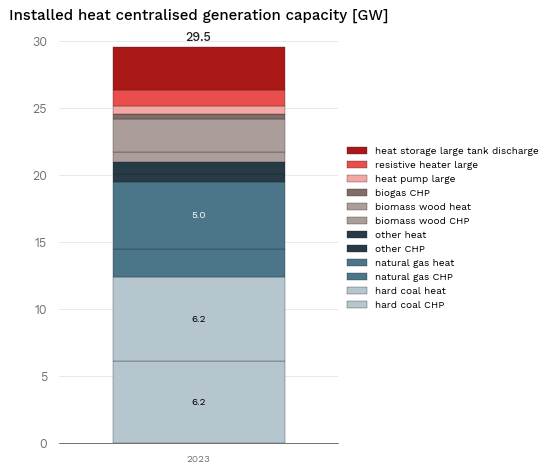

In [26]:
from pypsa_pl.plot_outputs import plot_installed_capacities

fig, df = plot_installed_capacities(
    network,
    bus_carriers=["heat centralised in"],
    carrier_name="heat centralised",
)
df = append_annual_sum(df)
df

,year,carrier,value
0,2023,biomass wood boiler,24.70
1,2023,hard coal boiler,13.82
2,2023,heat pump small,13.17
3,2023,heat storage small discharge,2.00
4,2023,natural gas boiler,26.54
5,2023,other RES heat,1.20
6,2023,other boiler,1.31
7,2023,resistive heater small,16.65
0,2023,SUM,99.39


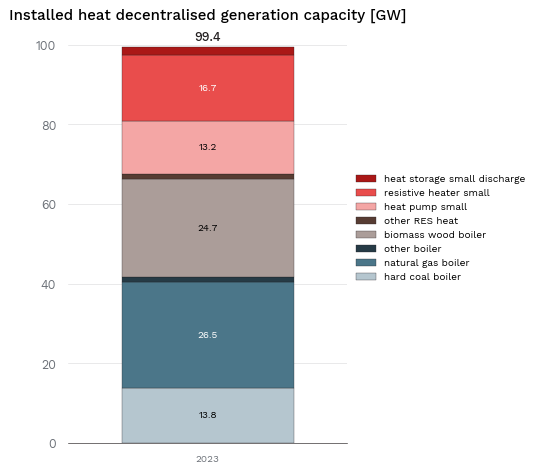

In [27]:
from pypsa_pl.plot_outputs import plot_installed_capacities

fig, df = plot_installed_capacities(
    network,
    bus_carriers=["heat decentralised"],
    carrier_name="heat decentralised",
    capacity_type="generation",
)

df = append_annual_sum(df)
df

,year,carrier,value
0,2023,BEV V2G,0.00
1,2023,battery large power,0.00
2,2023,biogas CHP,0.00
3,2023,biomass wood CHP,0.00
4,2023,biomass wood power,0.00
5,2023,hard coal CHP,-1.45
6,2023,hard coal power,0.00
7,2023,hydro PSH power,0.00
8,2023,hydro ROR,0.00
9,2023,lignite power,0.00


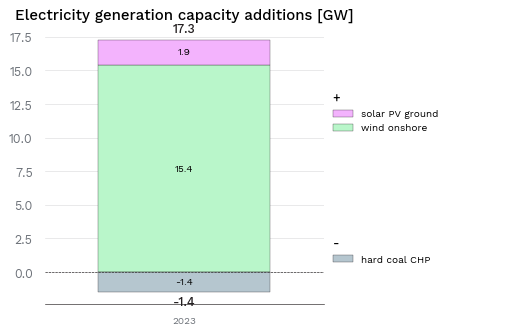

In [28]:
from pypsa_pl.plot_outputs import plot_capacity_additions

fig, df = plot_capacity_additions(
    network,
    bus_carriers=["electricity in"],
    carrier_name="electricity",
    capacity_type="generation",
)

df = append_annual_sum(df)
df

,year,carrier,value
0,2023,biogas CHP,0.00
1,2023,biomass wood CHP,0.00
2,2023,biomass wood heat,0.00
3,2023,hard coal CHP,-2.42
4,2023,hard coal heat,-27.99
5,2023,heat pump large,0.60
6,2023,heat storage large tank discharge,1.20
7,2023,natural gas CHP,0.00
8,2023,natural gas heat,0.00
9,2023,other CHP,0.00


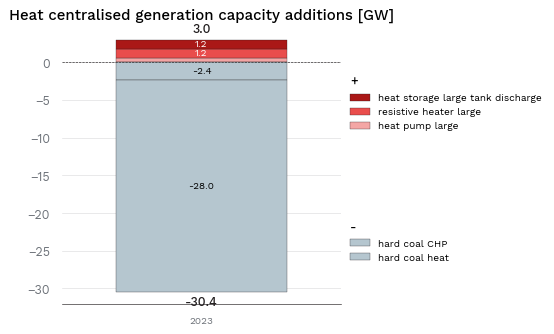

In [29]:
from pypsa_pl.plot_outputs import plot_capacity_additions

fig, df = plot_capacity_additions(
    network,
    bus_carriers=["heat centralised in"],
    carrier_name="heat centralised",
    capacity_type="generation",
)

df = append_annual_sum(df)
df

,year,carrier,value
0,2023,biomass wood boiler,0.00
1,2023,hard coal boiler,-7.85
2,2023,heat pump small,8.00
3,2023,heat storage small discharge,2.00
4,2023,natural gas boiler,-0.00
5,2023,other RES heat,0.00
6,2023,other boiler,0.00
7,2023,resistive heater small,8.00
0,2023,SUM,10.15


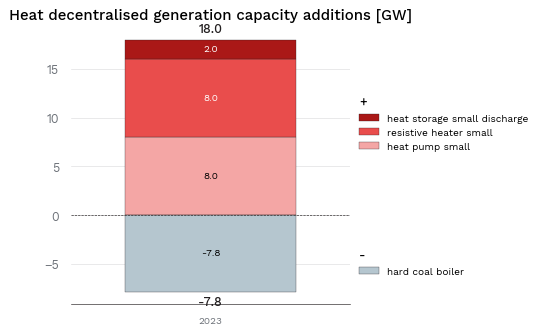

In [30]:
from pypsa_pl.plot_outputs import plot_capacity_additions

fig, df = plot_capacity_additions(
    network,
    bus_carriers=["heat decentralised"],
    carrier_name="heat decentralised",
    capacity_type="generation",
)

df = append_annual_sum(df)
df

,year,carrier,value
0,2023,battery large storage,0.60
1,2023,heat storage large tank,19.20
2,2023,heat storage small,4.00
3,2023,hydro PSH storage,8.47
4,2023,hydrogen storage,0.00
0,2023,SUM,32.27


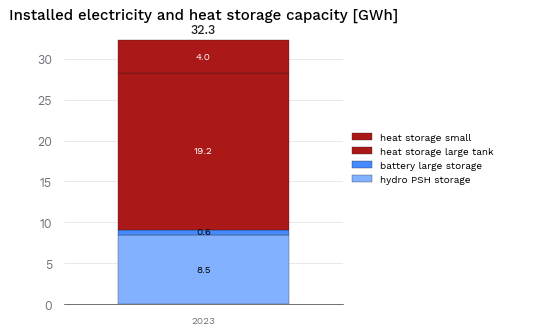

In [31]:
from pypsa_pl.plot_outputs import plot_storage_capacities

fig, df = plot_storage_capacities(
    network, 
    bus_carriers=[
        "battery large electricity", 
        "hydro PSH electricity", 
        "heat storage large tank heat",
        "heat storage small heat",
        "hydrogen"
    ],
    carrier_name="electricity and heat",
)

df = append_annual_sum(df)
df

,year,carrier,value
0,2023,battery large storage,0.0
1,2023,heat storage large tank,7.2
2,2023,heat storage small,0.0
3,2023,hydro PSH storage,0.0
0,2023,SUM,7.2


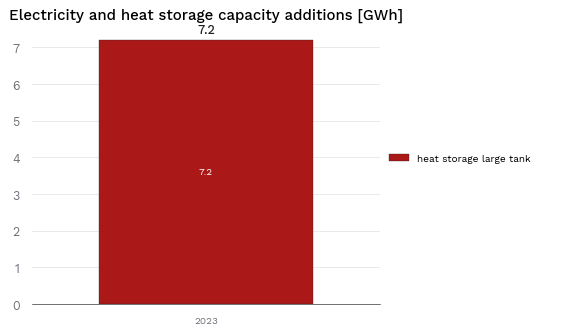

In [32]:
from pypsa_pl.plot_outputs import plot_storage_capacity_additions

fig, df = plot_storage_capacity_additions(
    network, 
    bus_carriers=[
        "battery large electricity", 
        "hydro PSH electricity", 
        "heat storage large tank heat",
        "heat storage small heat",
    ],
    carrier_name="electricity and heat",
)

df = append_annual_sum(df)
df

#### Plot generation mixes

,year,carrier,value
0,2023,BEV V2G,0.00
1,2023,BEV charger,-4.17
2,2023,battery large charger,-0.19
3,2023,battery large power,0.17
4,2023,biogas CHP,0.72
5,2023,biomass wood CHP,2.79
6,2023,biomass wood power,2.30
7,2023,electricity final use,-139.00
8,2023,electricity grid,-6.74
9,2023,hard coal CHP,10.94


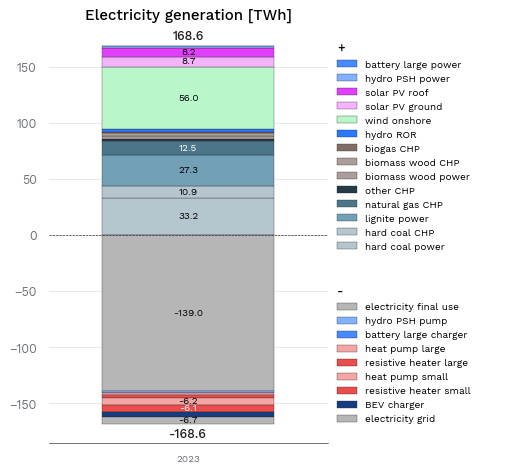

In [33]:
from pypsa_pl.plot_outputs import plot_annual_generation

fig, df = plot_annual_generation(
    network,
    bus_carriers=["electricity in", "electricity out"],
    carrier_name="electricity",
)

df = append_annual_sum(df)
df

,year,carrier,value
0,2023,biogas CHP,8.400000e-01
1,2023,biomass wood CHP,4.830000e+00
2,2023,biomass wood heat,7.100000e-01
3,2023,centralised other heating,-1.520000e+01
4,2023,centralised space heating,-4.152000e+01
5,2023,centralised water heating,-1.353000e+01
6,2023,district heating,-7.810000e+00
7,2023,hard coal CHP,1.823000e+01
8,2023,hard coal heat,3.237000e+01
9,2023,heat pump large,5.060000e+00


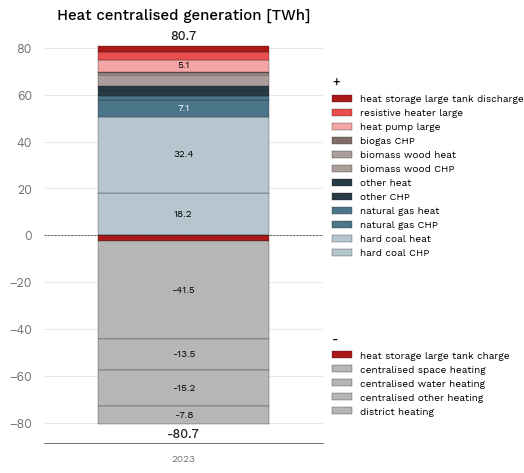

In [34]:
fig, df = plot_annual_generation(
    network,
    bus_carriers=["heat centralised in", "heat centralised out"],
    carrier_name="heat centralised",
)

df = append_annual_sum(df)
df

,year,carrier,value
0,2023,biomass wood boiler,4.327000e+01
1,2023,decentralised space heating,-1.112800e+02
2,2023,decentralised water heating,-3.627000e+01
3,2023,hard coal boiler,2.420000e+01
4,2023,heat pump small,2.324000e+01
5,2023,heat storage small charge,-1.950000e+00
6,2023,heat storage small discharge,1.790000e+00
7,2023,natural gas boiler,4.650000e+01
8,2023,other RES heat,2.100000e+00
9,2023,other boiler,2.300000e+00


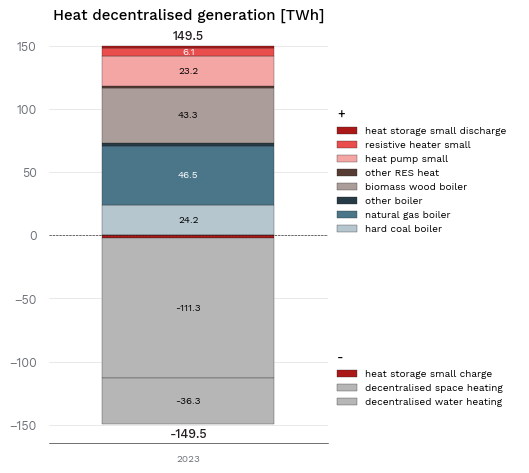

In [35]:
fig, df = plot_annual_generation(
    network,
    bus_carriers=["heat decentralised"],
    carrier_name="heat decentralised",
)

df = append_annual_sum(df)
df

#### Plot fuel consumption and CO2 emissions

,year,fuel,value
0,2023,ICE vehicle fuel,600.6
1,2023,biogas,6.3
2,2023,biomass wood,275.2
3,2023,hard coal,738.3
4,2023,lignite,280.6
5,2023,natural gas,416.0
6,2023,other fuel,40.5
0,2023,SUM,2357.5


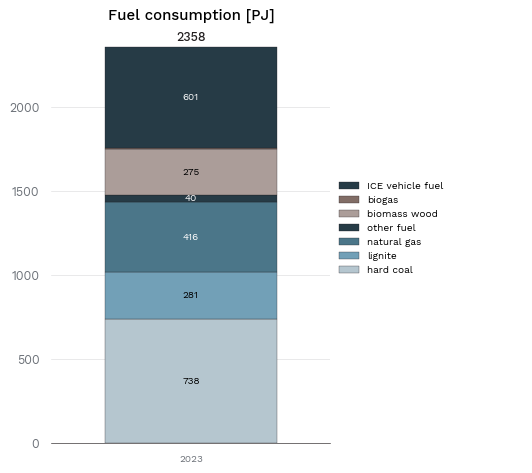

In [36]:
from pypsa_pl.plot_outputs import plot_fuel_consumption

fig, df = plot_fuel_consumption(network)

df = append_annual_sum(df)
df

,year,fuel,value
0,2023,ICE vehicle fuel,41.71
1,2023,hard coal,69.73
2,2023,lignite,31.18
3,2023,natural gas,23.11
4,2023,other fuel,3.04
0,2023,SUM,168.77


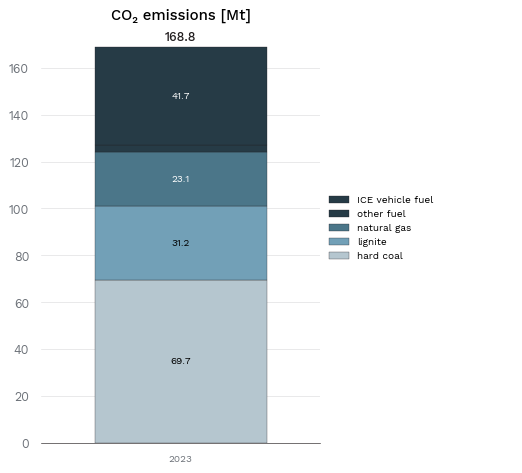

In [37]:
from pypsa_pl.plot_outputs import plot_co2_emissions

fig, df = plot_co2_emissions(network)

df = append_annual_sum(df)
df

#### Plot hourly electricity generation

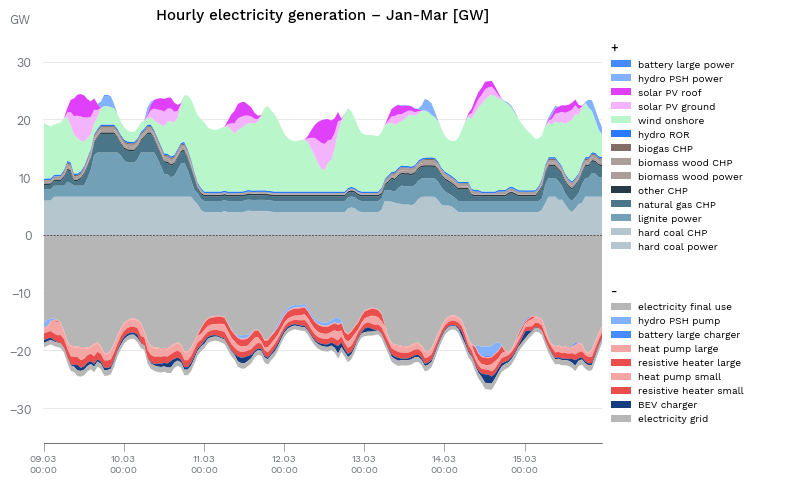

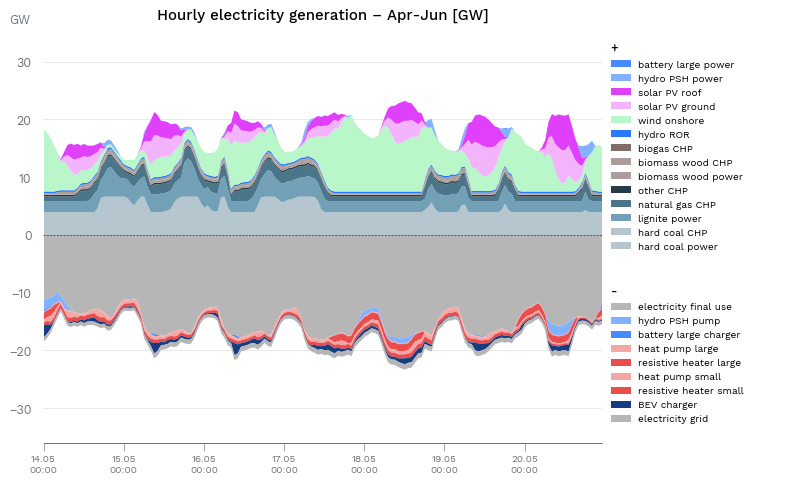

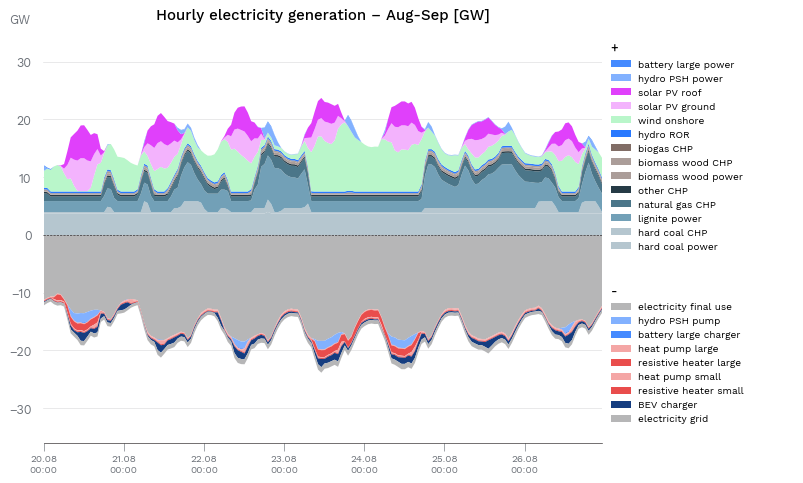

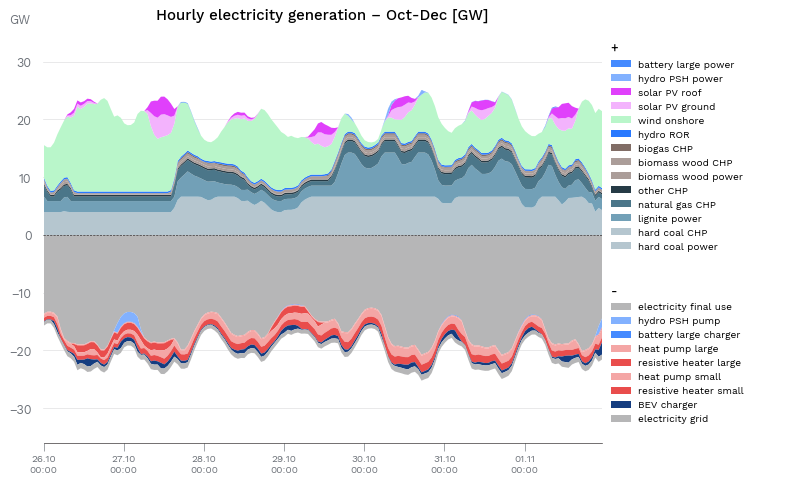

In [38]:
from pypsa_pl.plot_outputs import plot_hourly_generation

n_per_subperiod = 7 * 24
subperiods = [
    (subperiod, (i * n_per_subperiod, (i + 1) * n_per_subperiod))
    for i, subperiod in enumerate(["Jan-Mar", "Apr-Jun", "Aug-Sep", "Oct-Dec"])
]

fig, df = plot_hourly_generation(
    network,
    bus_carriers=["electricity in", "electricity out"],
    carrier_name="electricity",
    subperiods=subperiods,
    ylim=(-36, 36),
)

In [39]:
df

carrier,BEV V2G,BEV charger,battery large charger,battery large power,biogas CHP,biomass wood CHP,biomass wood power,electricity final use,electricity grid,hard coal CHP,...,hydro ROR,hydrogen electrolysis,lignite power,natural gas CHP,other CHP,resistive heater large,resistive heater small,solar PV ground,solar PV roof,wind onshore
2023-03-09 00:00:00,0.0,-0.523,-0.087,0.0,0.036,0.442,0.100,-15.154,-0.777,2.215,...,0.276,0.0,1.91,0.785,0.275,-0.062,-1.128,0.0,0.0,9.590
2023-03-09 01:00:00,0.0,-0.476,-0.099,0.0,0.036,0.442,0.100,-14.630,-0.765,2.245,...,0.276,0.0,1.91,0.785,0.275,-0.060,-1.133,0.0,0.0,9.283
2023-03-09 02:00:00,0.0,-0.402,-0.096,0.0,0.036,0.442,0.100,-14.439,-0.755,2.256,...,0.276,0.0,1.91,0.785,0.275,-0.042,-1.133,0.0,0.0,9.001
2023-03-09 03:00:00,0.0,-0.244,-0.074,0.0,0.036,0.442,0.100,-14.424,-0.766,2.882,...,0.276,0.0,1.91,0.785,0.275,-0.103,-1.155,0.0,0.0,8.667
2023-03-09 04:00:00,0.0,-0.081,0.000,0.0,0.036,0.442,0.100,-14.630,-0.774,2.905,...,0.276,0.0,1.91,0.785,0.275,-0.184,-1.218,0.0,0.0,8.847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01 19:00:00,0.0,-0.512,0.000,0.0,0.146,0.442,0.115,-19.533,-0.932,1.803,...,0.276,0.0,1.91,1.985,0.275,0.000,-1.049,0.0,0.0,12.567
2023-11-01 20:00:00,0.0,-0.506,0.000,0.0,0.138,0.442,0.100,-18.851,-0.902,1.722,...,0.276,0.0,1.91,0.872,0.275,0.000,-1.033,0.0,0.0,13.039
2023-11-01 21:00:00,0.0,-0.571,-0.040,0.0,0.036,0.442,0.100,-17.423,-0.847,0.299,...,0.276,0.0,1.91,0.785,0.275,-0.016,-0.990,0.0,0.0,13.263
2023-11-01 22:00:00,0.0,-1.188,-0.142,0.0,0.036,0.442,0.100,-15.709,-0.876,0.963,...,0.276,0.0,1.91,0.785,0.275,-0.092,-0.901,0.0,0.0,13.337


#### Plot centralised heat generation

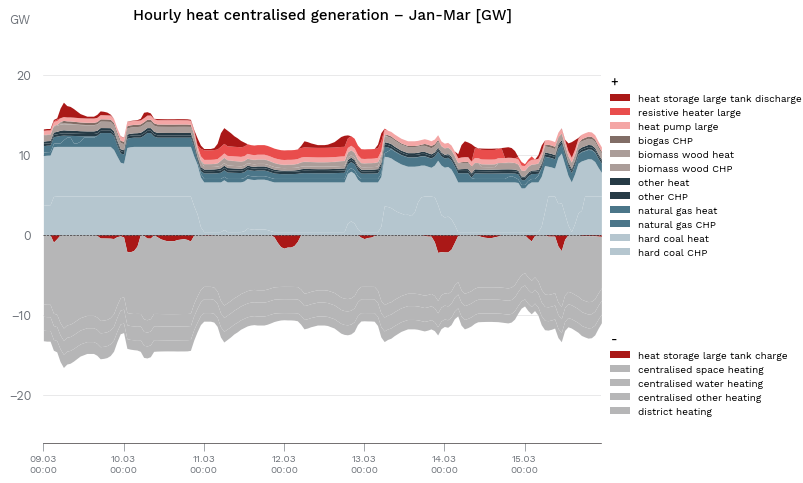

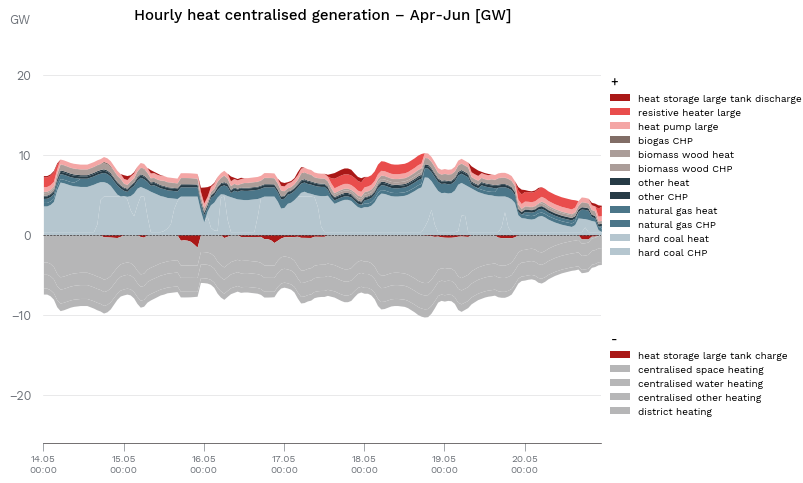

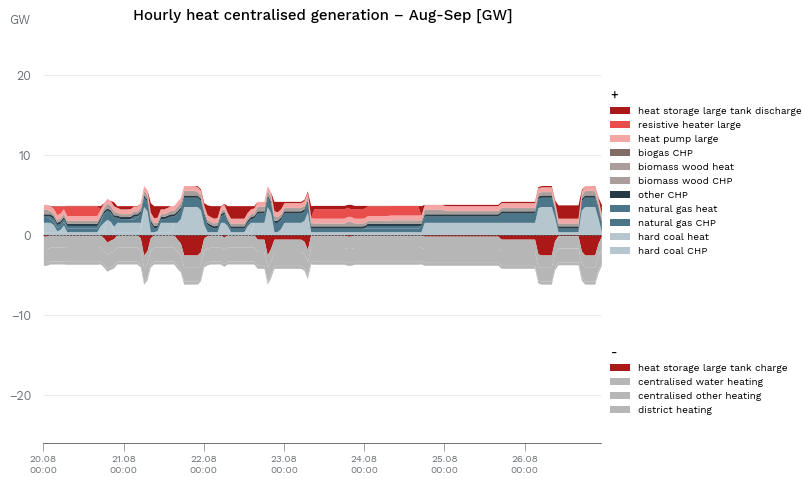

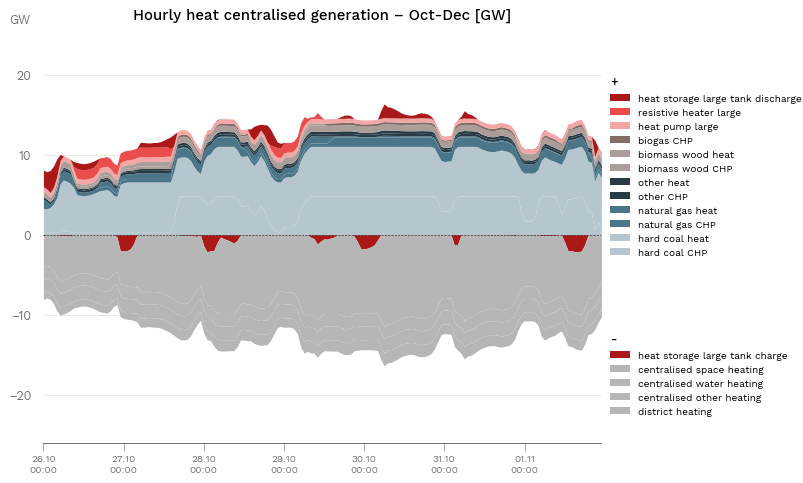

In [40]:
from pypsa_pl.plot_outputs import plot_hourly_generation

n_per_subperiod = 7 * 24
subperiods = [
    (subperiod, (i * n_per_subperiod, (i + 1) * n_per_subperiod))
    for i, subperiod in enumerate(["Jan-Mar", "Apr-Jun", "Aug-Sep", "Oct-Dec"])
]

fig, df = plot_hourly_generation(
    network,
    bus_carriers=["heat centralised in", "heat centralised out"],
    carrier_name="heat centralised",
    subperiods=subperiods,
    ylim=(-26, 26),
)

#### Plot total overnight investment costs

,year,aggregation,value
23,2023,heat pump large,3.24
24,2023,heat pump small,28.00
25,2023,heat storage large,0.27
26,2023,heat storage small,1.20
47,2023,resistive heater large,0.53
49,2023,solar PV ground,6.31
51,2023,wind onshore,109.24
0,2023,SUM,148.79


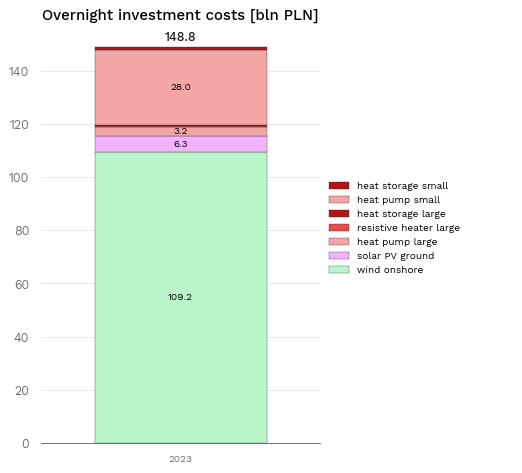

In [41]:
from pypsa_pl.plot_outputs import plot_capex

fig, df = plot_capex(network, cost_attr="investment_cost")

df = append_annual_sum(df)

df

#### Plot total annual costs

Objective value: 205.3


,year,aggregation,value
0,2023,BEV,1.7360
1,2023,ICE vehicle,22.6715
2,2023,ICE vehicle fuel supply,45.8771
3,2023,battery large,0.0027
4,2023,biogas CHP,0.0510
5,2023,biogas production,0.2487
6,2023,biogas substrate supply,0.3495
7,2023,biomass CHP,0.5105
8,2023,biomass heat,0.5555
9,2023,biomass power,0.3045


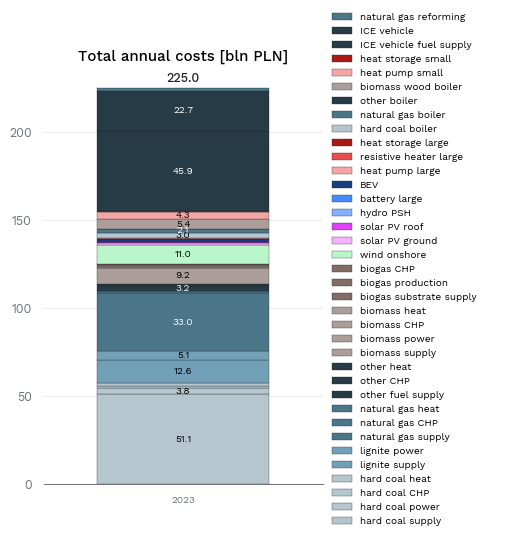

In [42]:
from pypsa_pl.plot_outputs import plot_total_costs

fig, df = plot_total_costs(network, costs=["OPEX", "CAPEX"])

df = append_annual_sum(df)

# Objective and objective_constant values cover operational costs of all capacities and capital costs 
# of the extendable capacities only - that's why their sum might differ from the total annual cost
if not hasattr(network, "objective_constant"):
    network.objective_constant = 0
objective_value = np.round((network.objective + network.objective_constant) / 1e9, 1)
print("Objective value:", objective_value)

df

#### Plot annual cost structure

cost component,year,aggregation,Var. O&M,CO₂,Fix. O&M,Ann. invest.,SUM
0,2023,BEV,0.00,0.00,1.74,0.00,1.74
1,2023,ICE vehicle,0.00,0.00,22.67,0.00,22.67
2,2023,ICE vehicle fuel supply,30.03,15.85,0.00,0.00,45.88
3,2023,biogas CHP,0.03,0.00,0.02,0.00,0.05
4,2023,biogas production,0.00,0.00,0.24,0.00,0.24
5,2023,biogas substrate supply,0.35,0.00,0.00,0.00,0.35
6,2023,biomass CHP,0.08,0.00,0.43,0.00,0.51
7,2023,biomass heat,0.01,0.00,0.54,0.00,0.55
8,2023,biomass power,0.06,0.00,0.24,0.00,0.30
9,2023,biomass supply,9.17,0.00,0.00,0.00,9.17


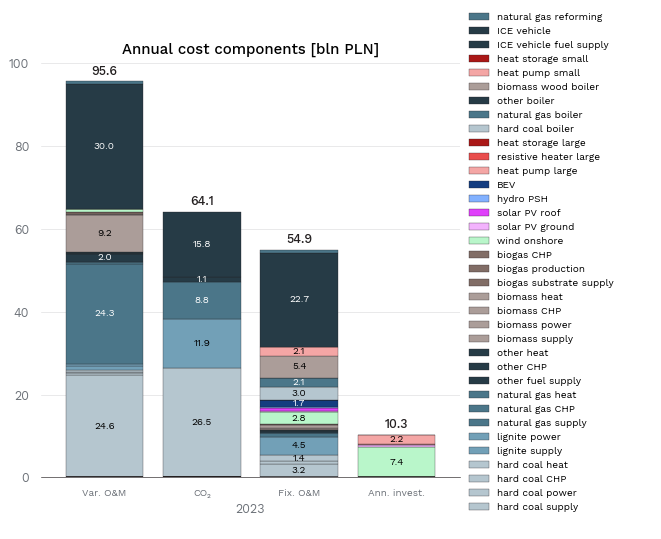

In [43]:
from pypsa_pl.plot_outputs import plot_detailed_costs

fig, df = plot_detailed_costs(network)

df = df.pivot(index="aggregation", columns="cost component", values="value").fillna(0)
columns = list(df.columns)

df["SUM"] = df.sum(axis=1)
df = df.reset_index().assign(year=params["year"])
df = append_annual_sum(df, value_cols=columns+["SUM"])
df = df.set_index(["year", "aggregation"]).reset_index()

df

### Sensitivity analysis: cost assumptions

In [44]:
import logging
import numpy as np
from matplotlib import pyplot as plt
from io import BytesIO
import ipywidgets as widgets
from ipywidgets import interact_manual

from pypsa_pl.helper_functions import suppress_stdout
from pypsa_pl.mathematical_operations import calculate_annuity

In [45]:
default_p_min_pu = 0.25


def update_p_min_pu_of_public_power_plants(network, p_min_pu=default_p_min_pu):
    is_public_pp = network.links["carrier"].isin(
        ["hard coal power", "lignite power", "biomass wood power"]
    ) & (network.links["qualifier"] == "public")
    if network.meta["reverse_links"]:
        network.links.loc[is_public_pp, "p_max_pu"] = -p_min_pu
    else:
        network.links.loc[is_public_pp, "p_min_pu"] = p_min_pu
    return network

In [46]:
eur_to_pln = 4.54  # 2023 exchange rate
default_co2_price = 83  # in EUR/tCO2


def update_co2_costs(network, co2_price=default_co2_price):
    co2_price_pln = round(co2_price * eur_to_pln, -1)
    logging.info(f"Setting CO2 price to {co2_price_pln} PLN/tCO2")

    fossil_carriers = [
        "hard coal supply",
        "lignite supply",
        "natural gas supply",
        "other fuel supply",
    ]
    is_fossil_supply = network.generators["carrier"].isin(fossil_carriers)
    co2_cost = (
        network.carriers.loc[fossil_carriers, "co2_emissions"] * co2_price_pln
    ).rename("co2_cost")
    co2_cost = pd.merge(
        network.generators.loc[is_fossil_supply, "carrier"],
        co2_cost,
        left_on="carrier",
        right_index=True,
        how="left",
    )["co2_cost"]

    network.generators.loc[is_fossil_supply, "co2_cost"] = co2_cost
    network.generators["marginal_cost"] = (
        network.generators["co2_cost"] + network.generators["variable_cost"]
    )

In [47]:
for component in ["Generator", "Link", "Store"]:
    network.df(component)["default_investment_cost"] = network.df(component)[
        "investment_cost"
    ]

default_discount_rate = params["discount_rate"]


def update_investment_costs(network, cost_factors={}):

    for name, value in cost_factors.items():
        name = name[: -len("_cost_factor")].replace("_", " ")
        is_cost_factor_links = network.links["carrier"].str.startswith(name)
        is_cost_factor_generators = network.generators["carrier"].str.startswith(name)
        is_cost_factor_stores = network.stores["carrier"].str.startswith(name)
        if any(is_cost_factor_links):
            network.links.loc[is_cost_factor_links, "investment_cost"] = (
                value
                * network.links.loc[is_cost_factor_links, "default_investment_cost"]
            )
        if any(is_cost_factor_generators):
            network.generators.loc[is_cost_factor_generators, "investment_cost"] = (
                value
                * network.generators.loc[
                    is_cost_factor_generators, "default_investment_cost"
                ]
            )
        if any(is_cost_factor_stores):
            network.stores.loc[is_cost_factor_stores, "investment_cost"] = (
                value
                * network.stores.loc[is_cost_factor_stores, "default_investment_cost"]
            )


def update_discount_rate(network, params, discount_rate=default_discount_rate):
    params["discount_rate"] = discount_rate
    for component in ["Generator", "Link", "Store"]:
        has_investment_cost = network.df(component)["lifetime"] > 1
        network.df(component).loc[
            has_investment_cost, "annual_investment_cost"
        ] = network.df(component).loc[
            has_investment_cost, "investment_cost"
        ] * calculate_annuity(
            lifetime=network.df(component).loc[has_investment_cost, "lifetime"],
            discount_rate=discount_rate,
        )
        network.df(component)["capital_cost"] = (
            network.df(component)["fixed_cost"]
            + network.df(component)["annual_investment_cost"]
        )

In [48]:
default_investment_technologies = [
    tech
    for tech in params["investment_technologies"]
    if tech
    not in [
        "battery large power",
        "battery large charger",
        "battery large storage",
        "heat storage large tank discharge",
        "heat storage large tank charge",
        "heat storage large tank",
        "heat storage small discharge",
        "heat storage small charge",
        "heat storage small",
        "BEV",
        "BEV battery",
        "BEV charger",
    ]
] + [
    "battery large",
    "heat storage large",
    "heat storage small",
    "BEV",
]

available_investment_technologies = default_investment_technologies

const_retirement_technologies = [
    "centralised space heating",
    "centralised water heating",
    "centralised other heating",
    "decentralised space heating",
    "decentralised water heating",
    "light vehicle mobility",
    "hydrogen",
]
default_retirement_technologies = [
    tech
    for tech in params["retirement_technologies"]
    if tech not in const_retirement_technologies
]
available_retirement_technologies = [
    "hard coal power old",
    "hard coal power SC",
    "lignite power old",
    "lignite power SC",
] + default_retirement_technologies


def update_extendability(
    network,
    params,
    investment_technologies=default_investment_technologies,
    retirement_technologies=default_retirement_technologies,
):

    if "battery large" in investment_technologies:
        investment_technologies = investment_technologies + [
            "battery large power",
            "battery large charger",
            "battery large storage",
        ]
    if "heat storage large" in investment_technologies:
        investment_technologies += [
            "heat storage large tank discharge",
            "heat storage large tank charge",
            "heat storage large tank",
        ]
    if "heat storage small" in investment_technologies:
        investment_technologies += [
            "heat storage small discharge",
            "heat storage small charge",
            "heat storage small",
        ]
    if "BEV" in investment_technologies:
        investment_technologies += [
            "BEV",
            "BEV battery",
            "BEV charger",
        ]

    retirement_technologies += const_retirement_technologies

    params["investment_technologies"] = investment_technologies
    params["retirement_technologies"] = retirement_technologies

    for component, nom_attr in [
        ("Generator", "p_nom"),
        ("Link", "p_nom"),
        ("Store", "e_nom"),
    ]:
        network.df(component)[f"{nom_attr}_min"] = network.df(component)[nom_attr]
        network.df(component)[f"{nom_attr}_max"] = network.df(component)[nom_attr]

        is_domestic = network.df(component)["area"].str.startswith("PL")
        is_cumulative = network.df(component)["lifetime"] == 1
        is_active = network.df(component)["build_year"] == network.meta["year"]
        is_to_invest = (
            network.df(component)["technology"].isin(investment_technologies)
            & is_domestic
            & is_active
            & ~is_cumulative
        )
        is_to_retire = (
            network.df(component)["technology"].isin(retirement_technologies)
            & is_domestic
            & is_active
            & is_cumulative
        )
        network.df(component)[f"{nom_attr}_extendable"] = is_to_invest | is_to_retire
        network.df(component).loc[is_to_invest, f"{nom_attr}_max"] = np.inf
        network.df(component).loc[is_to_retire, f"{nom_attr}_min"] = 0

In [49]:
from pypsa_pl.plot_outputs import plot_curtailed_vres_energy

n_per_subperiod = 7 * 24
subperiods = [
    (subperiod, (i * n_per_subperiod, (i + 1) * n_per_subperiod))
    for i, subperiod in enumerate(["Jan-Mar", "Apr-Jun", "Aug-Sep", "Oct-Dec"])
]

figure_width = 7


def list_plotting_tasks():
    return [
        (
            plot_hourly_generation,
            dict(subperiods=[subperiods[1]], ylim=(-41, 41), figsize=(figure_width, 6)),
        ),
        (
            plot_installed_capacities,
            dict(
                ylim=(0, 115),
                bus_carriers=["electricity in"],
                carrier_name="electricity",
                figsize=(figure_width, 6),
            ),
        ),
        (
            plot_installed_capacities,
            dict(
                ylim=(0, 60),
                bus_carriers=["heat centralised in"],
                carrier_name="heat centralised",
                figsize=(figure_width, 6),
            ),
        ),
        (
            plot_installed_capacities,
            dict(
                ylim=(0, 120),
                bus_carriers=["heat decentralised"],
                carrier_name="heat decentralised",
                figsize=(figure_width, 6),
            ),
        ),
        (
            plot_capacity_additions,
            dict(
                ylim=(-35, 75),
                bus_carriers=["electricity in"],
                carrier_name="electricity",
                figsize=(figure_width, 5),
            ),
        ),
        (
            plot_capacity_additions,
            dict(
                ylim=(-75, 75),
                bus_carriers=["heat centralised in"],
                carrier_name="heat centralised",
                figsize=(figure_width, 5),
            ),
        ),
        (
            plot_capacity_additions,
            dict(
                ylim=(-75, 75),
                bus_carriers=["heat decentralised"],
                carrier_name="heat decentralised",
                figsize=(figure_width, 5),
            ),
        ),
        (
            plot_storage_capacities,
            dict(
                ylim=(0, 65),
                bus_carriers=[
                    "battery large electricity",
                    "hydro PSH electricity",
                    "heat storage large tank heat",
                    "heat storage small heat",
                ],
                carrier_name="electricity and heat",
                figsize=(figure_width, 5),
            ),
        ),
        (
            plot_storage_capacity_additions,
            dict(
                ylim=(0, 65),
                bus_carriers=[
                    "battery large electricity",
                    "hydro PSH electricity",
                    "heat storage large tank heat",
                    "heat storage small heat",
                ],
                carrier_name="electricity and heat",
                figsize=(figure_width, 4),
            ),
        ),
        (
            plot_annual_generation,
            dict(
                ylim=(-215, 215),
                bus_carriers=["electricity in", "electricity out"],
                figsize=(figure_width, 6),
            ),
        ),
        (
            plot_annual_generation,
            dict(
                ylim=(-120, 120),
                bus_carriers=["heat centralised in", "heat centralised out"],
                carrier_name="heat centralised",
                figsize=(figure_width, 6),
            ),
        ),
        (
            plot_annual_generation,
            dict(
                ylim=(-200, 200),
                bus_carriers=["heat decentralised"],
                carrier_name="heat decentralised",
                figsize=(figure_width, 6),
            ),
        ),
        (
            plot_annual_generation,
            dict(
                ylim=(-35, 35),
                bus_carriers=["hydrogen"],
                carrier_name="hydrogen",
                figsize=(figure_width, 4),
            ),
        ),
        (
            plot_curtailed_vres_energy,
            dict(ylim=(0, 45), figsize=(figure_width, 4)),
        ),
        (
            plot_co2_emissions,
            dict(ylim=(0, 205), figsize=(figure_width, 5)),
        ),
        (
            plot_total_costs,
            dict(ylim=(0, 240), figsize=(figure_width, 6)),
        ),
        (
            plot_detailed_costs,
            dict(ylim=(0, 120), figsize=(figure_width, 6)),
        ),
        (
            plot_capex,
            dict(cost_attr="investment_cost", ylim=(0, 510), figsize=(figure_width, 5)),
        ),
    ]

In [50]:
def make_images(network):
    imgs = []
    for plot_func, kwargs in list_plotting_tasks():
        try:
            fig, _ = plot_func(network, **kwargs)
            img = BytesIO()
            fig.tight_layout()
            px_per_inch = 85
            fig.savefig(img, format="png", dpi=px_per_inch * 2)
            plt.close()
            img.seek(0)
            img = widgets.Image(value=img.read(), format="png")
            width, height = kwargs["figsize"]
            img.layout = widgets.Layout(
                height=f"{px_per_inch*height}px",
                width=f"{px_per_inch*width}px",
                margin="5px 5px 5px 5px",
                border="solid 1.5px darkgrey",
            )
            imgs.append(img)
        except:
            logging.warning(f"Failed to create image with '{plot_func.__name__}'")
    return imgs


def make_widgets(values, images):
    header_layout = widgets.Layout(
        min_height="480px",
        border="solid 1.5px darkgrey",
        margin="5px 5px 5px 5px",
        padding="5px 5px 5px 5px",
    )
    column_layout = widgets.Layout(
        margin="10px 5px 10px 5px",
        padding="5px 5px 5px 5px",
    )
    columns = []
    div_style = 'style="display: flex; flex-direction: column; justify-content: center; text-align: center; line-height:1.15"'
    h1_style = 'style="font-size: 1.44em; margin: 0.5em 0;"'
    ul_style = 'style="line-height:1.15; padding:0; margin-top:0;"'
    li_style = 'style="list-style-position: inside"'
    for key in ["previous", "current"]:
        html = f"""
            <div {div_style}>
                <div><h1 {h1_style}>{key.upper()} CALCULATION</h1></div>
                <div>p_min_pu: {values[key]['p_min_pu']:.0%}</div>
                <div>co2_price: {values[key]['co2_price']:.0f} EUR/tCO2</div>
                <div>discount_rate: {values[key]['discount_rate']:.1%}</div>"""
        if values[key]["cost_factors"]:
            html += f"""<div style="margin-top: 1em"><b>Cost factors:</b></div><div><ul {ul_style}>"""
            for cost_factor in values[key]["cost_factors"]:
                html += f"<li {li_style}>{cost_factor}: {values[key]['cost_factors'][f'{cost_factor}']:.0%}</li>"
            html += "</ul></div>"
        if values[key]["investment_technologies"]:
            html += f"<div><b>Investment technologies:</b></div><div><ul {ul_style}>"
            for tech in values[key]["investment_technologies"]:
                html += f"<li {li_style}>{tech}</li>"
            html += "</ul></div>"
        if values[key]["retirement_technologies"]:
            html += f"<div><b>Retirement technologies:</b></div><div><ul {ul_style}>"
            for tech in values[key]["retirement_technologies"]:
                html += f"<li {li_style}>{tech}</li>"
            html += "</ul></div>"
        html += f"</div>"
        header = widgets.HTML(value=html)
        header.layout = header_layout
        column = widgets.VBox([header] + images[key])
        column.layout = column_layout
        columns.append(column)

    return widgets.HBox(columns)

In [51]:
disallow_retirements = True

widget_kwargs = {
    "layout": widgets.Layout(align_self="center", min_width="40%"),
    "style": {"description_width": "30ch"},
}

cost_factor_levers = [
    "solar PV",
    "wind",
    "battery large",
    "heat pump large",
    "heat storage large",
    "heat pump small",
    "heat storage small",
    "hydrogen electrolysis",
]
default_cost_factors = {
    name.replace(" ", "_") + "_cost_factor": 1 for name in cost_factor_levers
}
cost_factors = {
    name.replace(" ", "_")
    + "_cost_factor": widgets.FloatSlider(
        1,
        min=0.1,
        max=2.001,
        step=0.05,
        description=f"{name} cost factor",
        **widget_kwargs,
    )
    for name in cost_factor_levers
}


values = {
    "previous": None,
    "current": {
        "p_min_pu": default_p_min_pu,
        "co2_price": default_co2_price,
        "cost_factors": default_cost_factors,
        "discount_rate": default_discount_rate,
        "investment_technologies": default_investment_technologies,
        "retirement_technologies": default_retirement_technologies,
    },
}
images = {"previous": None, "current": make_images(network)}


@interact_manual(
    p_min_pu=widgets.FloatSlider(
        default_p_min_pu, min=0, max=0.301, step=0.01, **widget_kwargs
    ),
    co2_price=widgets.FloatSlider(
        default_co2_price, min=0, max=180.01, step=1, **widget_kwargs
    ),
    discount_rate=widgets.FloatSlider(
        default_discount_rate, min=0, max=0.101, step=0.005, readout_format=".3f", **widget_kwargs
    ),
    investment_technologies=widgets.SelectMultiple(
        options=available_investment_technologies,
        value=default_investment_technologies,
        rows=len(available_investment_technologies),
        **widget_kwargs,
    ),
    retirement_technologies=widgets.SelectMultiple(
        options=available_retirement_technologies,
        value=default_retirement_technologies,
        rows=len(available_retirement_technologies),
        **widget_kwargs,
    ),
    **cost_factors,
).options(manual_name="Run Simulation")
def recalculate(
    p_min_pu,
    co2_price,
    discount_rate,
    investment_technologies,
    retirement_technologies,
    **cost_factors,
):

    if disallow_retirements and p_min_pu > 0 and sum("power" in tech for tech in retirement_technologies) > 0:
        logging.error(
            "Allowing retirement of conventional power plants with forced operation (p_min_pu > 0)"
            + " might generate misleading results. It is so because similar forced operation is not"
            + " required for investment candidate units. Assume high flexibility of conventional"
            + " power plants (p_min_pu = 0) or set 'disallow_retirements' variable to False."
        )
        return

    values["previous"] = values["current"]
    images["previous"] = images["current"]

    update_p_min_pu_of_public_power_plants(network, p_min_pu)
    update_co2_costs(network, co2_price)
    update_investment_costs(network, cost_factors)
    update_discount_rate(network, params, discount_rate)
    update_extendability(
        network, params, list(investment_technologies), list(retirement_technologies)
    )

    network.meta = params
    with suppress_stdout():
        optimise_network(network, params)

    logging.info("Generating result visualisations...")

    values["current"] = {
        "p_min_pu": p_min_pu,
        "co2_price": co2_price,
        "cost_factors": cost_factors,
        "discount_rate": discount_rate,
        "investment_technologies": list(investment_technologies),
        "retirement_technologies": list(retirement_technologies),
    }
    images["current"] = make_images(network)

    return make_widgets(values, images)

interactive(children=(FloatSlider(value=0.25, description='p_min_pu', layout=Layout(align_self='center', min_w…